In [155]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

import sklearn

In [166]:
folder_path = r"C:\Users\Alicia BASSIERE\OneDrive - GENES\Documents\Paper 02 - Mean Field\Data"
data = pd.read_csv(folder_path + r"\\auction_sample.csv" , index_col=0)
data = data[data['Sale/Purchase'] == "Sell"]
coal_price = 94
gas_price = 6.163
carbon_price = 26.97    # Ember climate org

# => Gas avant charbon évident

prod_data = pd.read_csv(folder_path + r"\\merit_order.csv", index_col=None)

production_costs = {
    "RES_other": 0,
    "PV": 0,
    "Wind": 0.25,
    "Base": 5,
    "Gas": 2.31 + 0.44 * gas_price + 0.33 * carbon_price,
    "Coal": 2.31 + 0.456 * coal_price + 0.96 * carbon_price,
    "Peak": 2.31 + 94 * 0.0019047619 * 1000 + 0.55 * carbon_price
}

production_costs_evaluated = {
    key: eval(str(value)) if isinstance(value, str) else value
    for key, value in production_costs.items()
}

# Extract the values to an array
costs_array = np.array(list(production_costs_evaluated.values()))

# Print the resulting array
print(costs_array)

[  0.          0.          0.25        5.         13.92182    71.0652
 196.1911186]


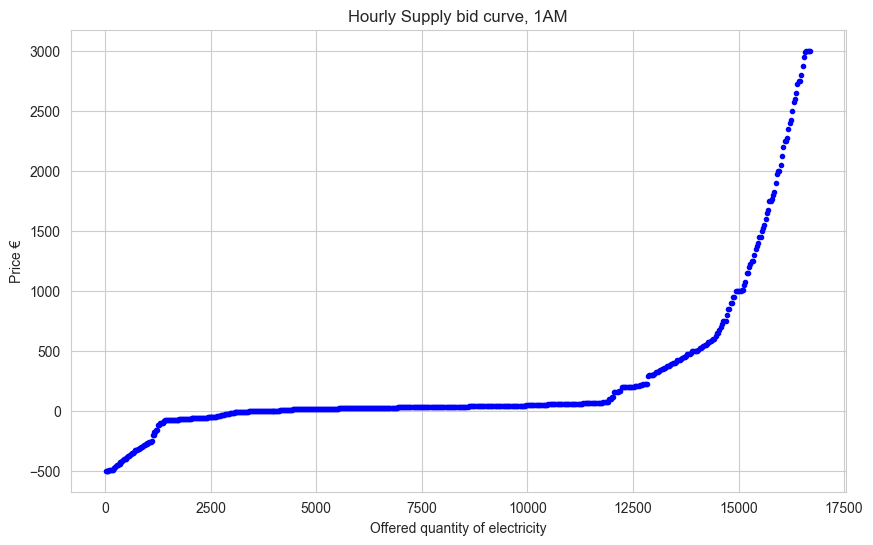

In [157]:
# Filter the initial DataFrame to keep rows where 'Hour' is 1
filtered_data1 = data[data['Hour'] == 1]
cumulative_volume = filtered_data1.groupby('Price')['Volume'].cumsum()/1000
cumulative_data = pd.DataFrame({'Price': filtered_data1['Price'], 'Cumulative_Volume': cumulative_volume})
cumulative_data = cumulative_data.drop_duplicates(subset='Price', keep='last')
cumulative_data.reset_index(drop=True, inplace=True)
cumulative_data = cumulative_data.sort_values(by='Price')
cumulative_data['Cumulative_Sum'] = cumulative_data['Cumulative_Volume'].cumsum()
cumulative_data['Diff'] = cumulative_data['Cumulative_Sum'].diff()
cumulative_data['diff de diff'] = cumulative_data['Diff'].diff()

cumulative_data.reset_index(drop=True, inplace=True)
biggest_jumps = cumulative_data.nlargest(3, 'diff de diff')
cumulative_data['Class'] = 0
jump_indices = sorted(biggest_jumps.index)
classes = range(len(jump_indices) + 1)

start_idx = 0
for class_label, end_idx in zip(classes, jump_indices + [len(cumulative_data)]):
    cumulative_data.loc[start_idx:end_idx, 'Class'] = class_label
    start_idx = end_idx + 1

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(cumulative_data['Cumulative_Sum'], cumulative_data['Price'], marker='.', color='blue')
plt.title('Hourly Supply bid curve, 1AM')
plt.xlabel('Offered quantity of electricity')
plt.ylabel('Price €')
plt.grid(True)

# Show the plot
plt.show()

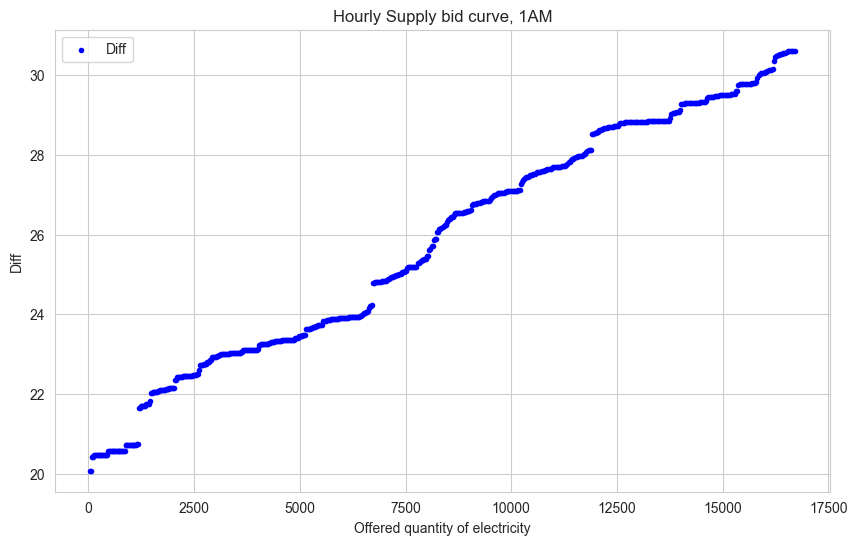

In [158]:
# First order difference

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(cumulative_data['Cumulative_Sum'][1:], cumulative_data['Diff'][1:], marker='.', color='blue', label='Diff')
plt.title('Hourly Supply bid curve, 1AM')
plt.xlabel('Offered quantity of electricity')
plt.ylabel('Diff')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

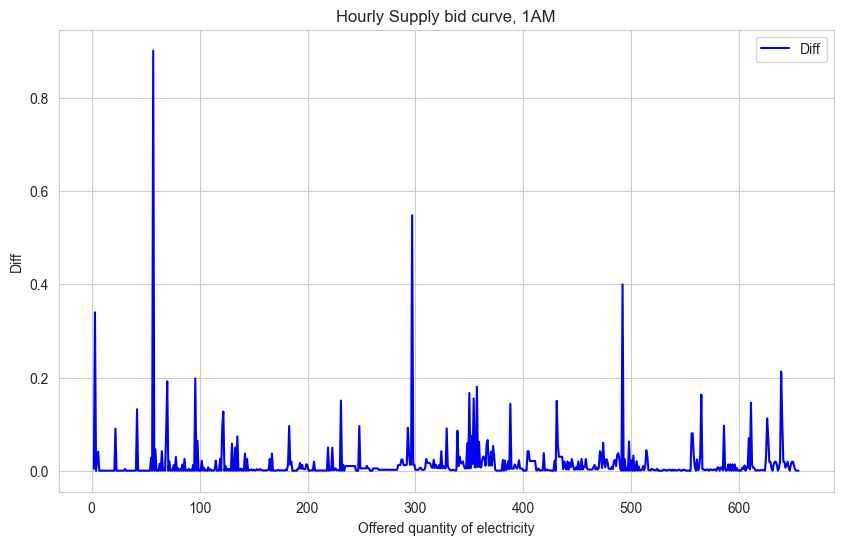

In [159]:
# Second order difference

plt.figure(figsize=(10, 6))
plt.plot(cumulative_data['diff de diff'], color='blue', label='Diff')
plt.title('Hourly Supply bid curve, 1AM')
plt.xlabel('Offered quantity of electricity')
plt.ylabel('Diff')
plt.grid(True)
plt.legend()


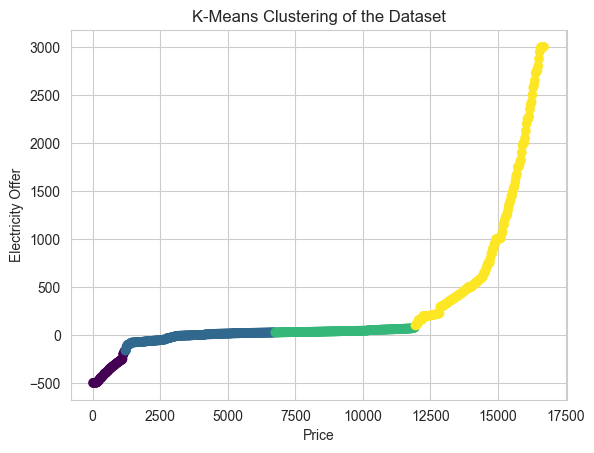

In [160]:
plt.scatter(cumulative_data['Cumulative_Sum'],cumulative_data['Price'], c=cumulative_data['Class'], cmap='viridis')
plt.xlabel('Price')
plt.ylabel('Electricity Offer')
plt.title('K-Means Clustering of the Dataset')
plt.show()


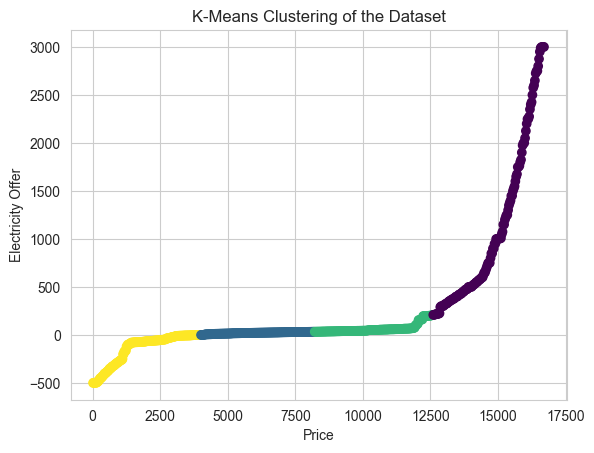

In [161]:
# Clustering approach

# Select the features for clustering
X = np.array(cumulative_data[['Price', 'Cumulative_Sum']].values)
# Initialize and fit the k-means model
# n_clusters is set to 4 as you wanted to classify the dataset into 4 categories
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(X)

# Predict the clusters
clusters = kmeans.predict(X)

# Assign the cluster back to your dataframe
cumulative_data['cluster'] = clusters

# Optionally, you can visualize the clustering (if it makes sense for your dataset)
plt.scatter(cumulative_data['Cumulative_Sum'],cumulative_data['Price'], c=cumulative_data['cluster'], cmap='viridis')
plt.xlabel('Price')
plt.ylabel('Electricity Offer')
plt.title('K-Means Clustering of the Dataset')
plt.show()

Hour:  1


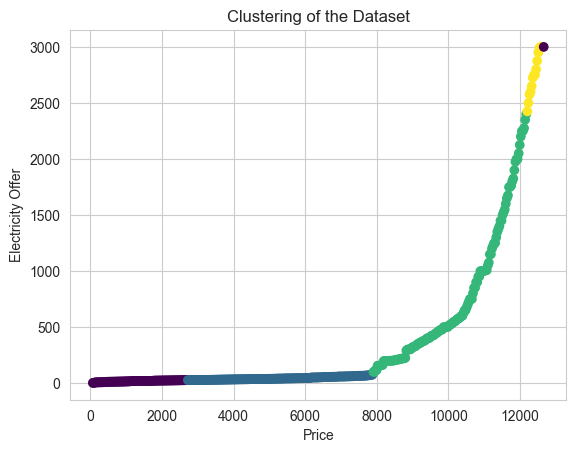

Hour:  2


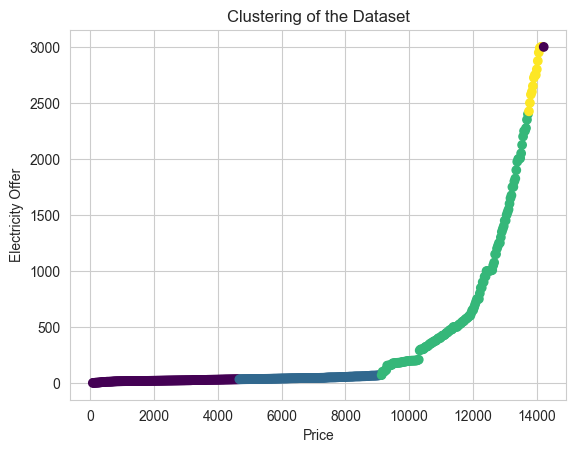

Hour:  3


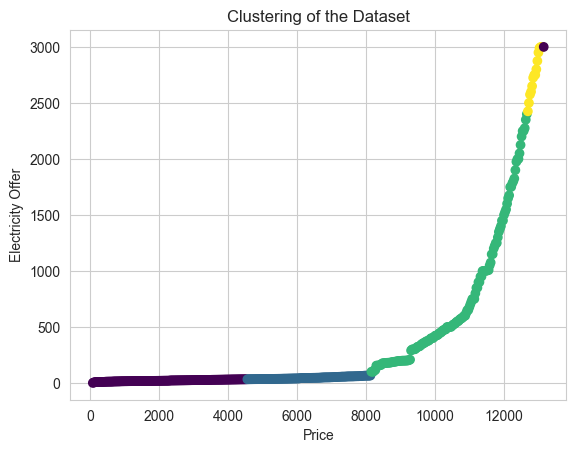

Hour:  4


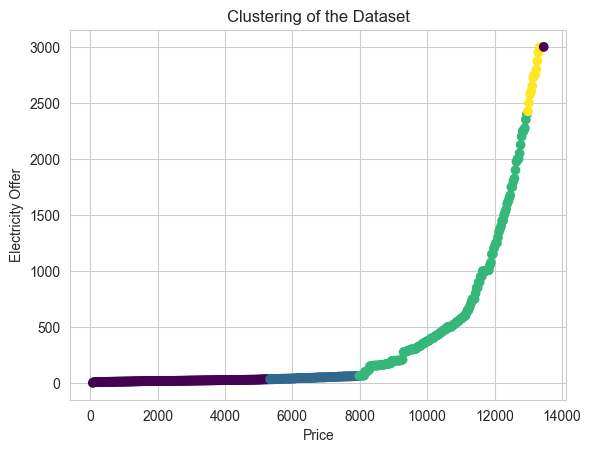

Hour:  5


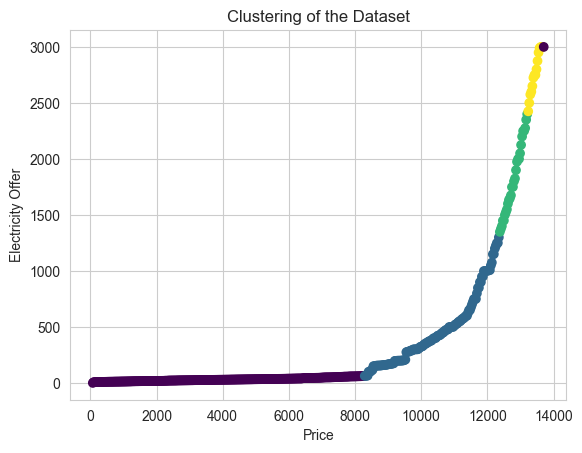

Hour:  6


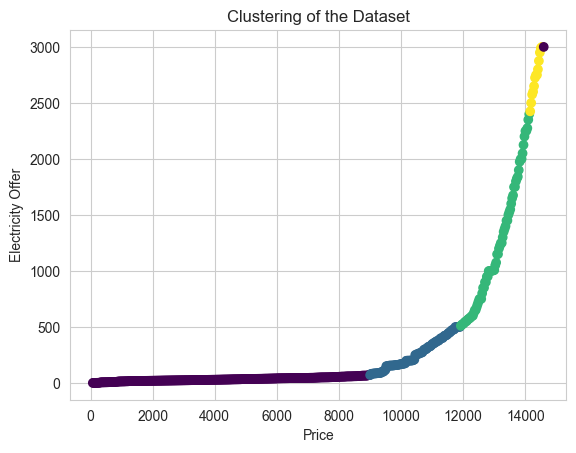

Hour:  7


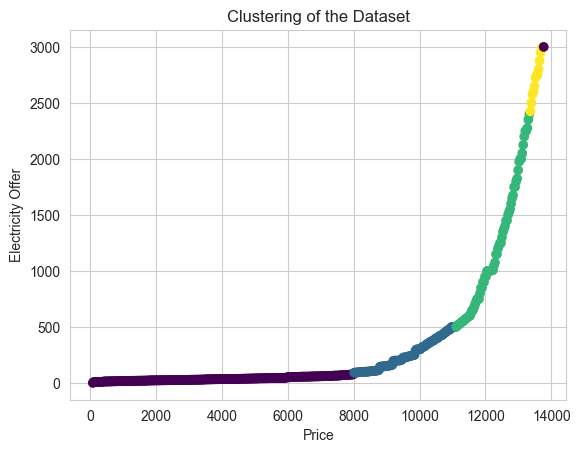

Hour:  8


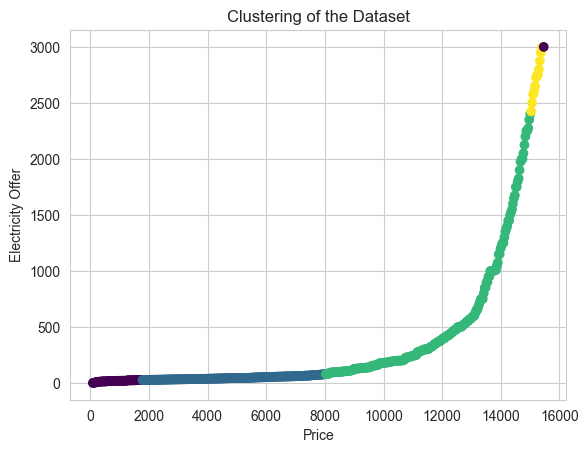

Hour:  9


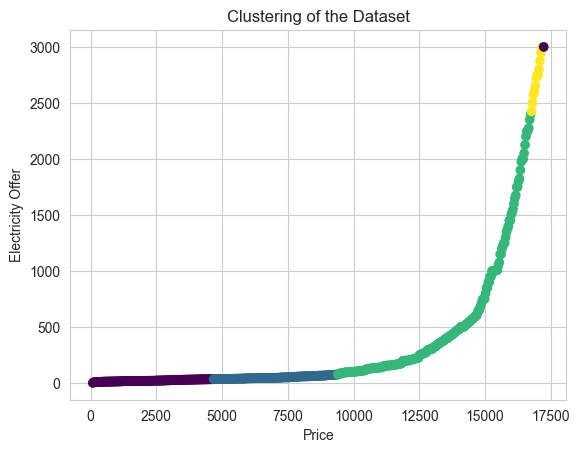

Hour:  10


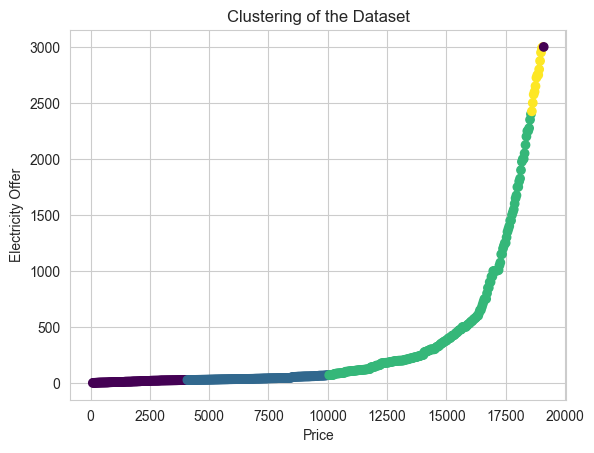

Hour:  11


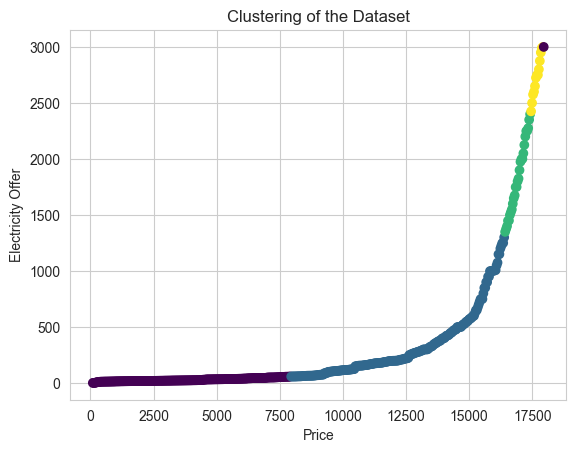

Hour:  12


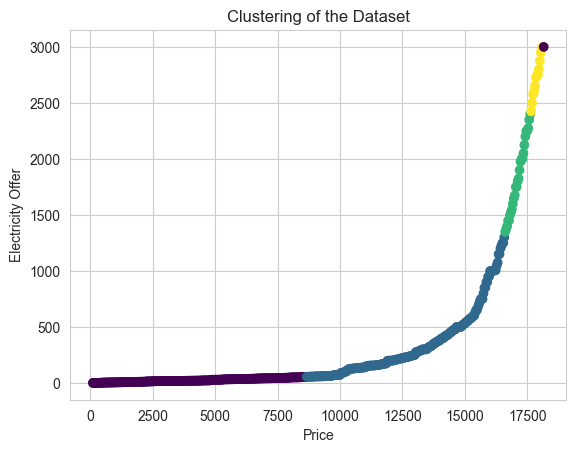

Hour:  13


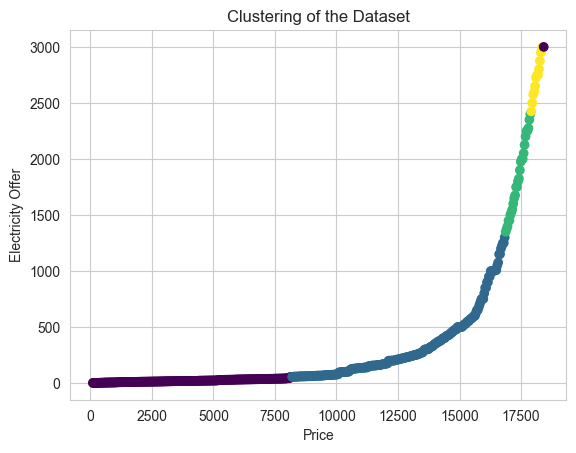

Hour:  14


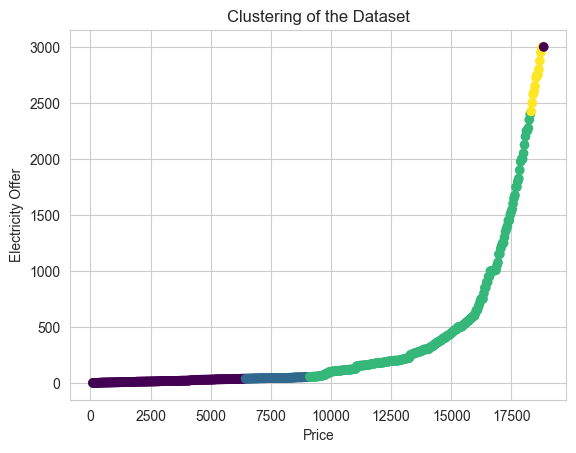

Hour:  15


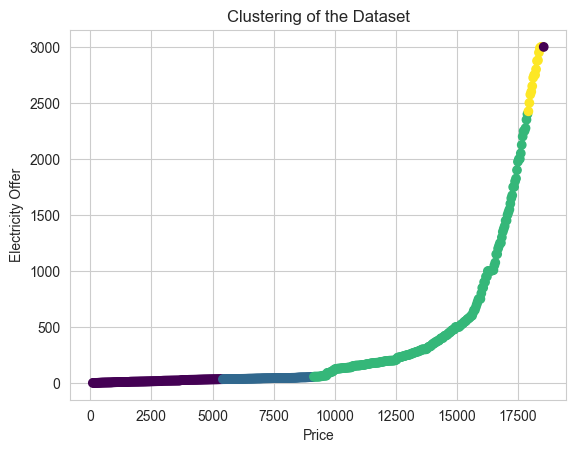

Hour:  16


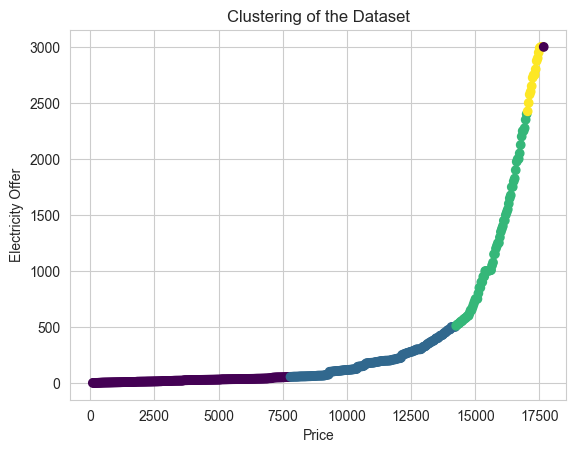

Hour:  17


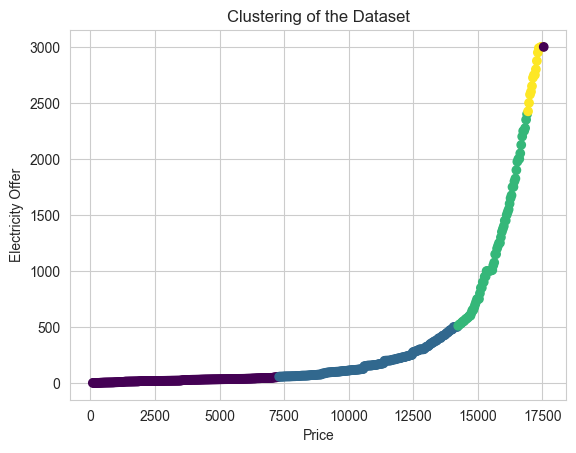

Hour:  18


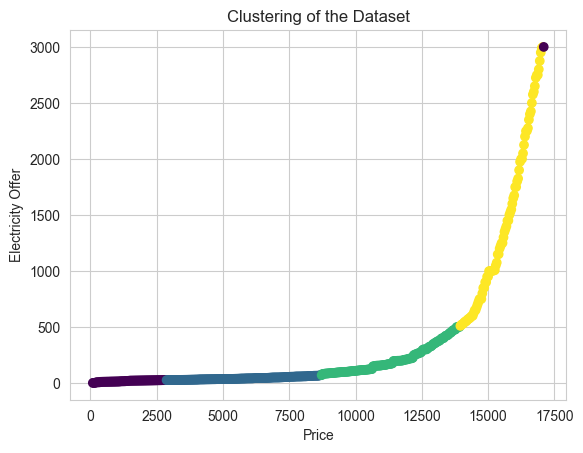

Hour:  19


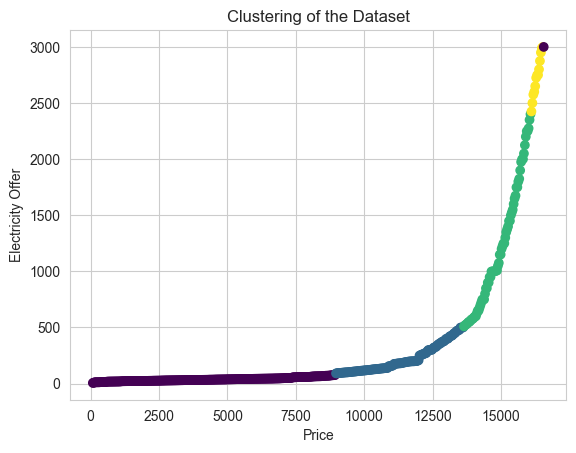

Hour:  20


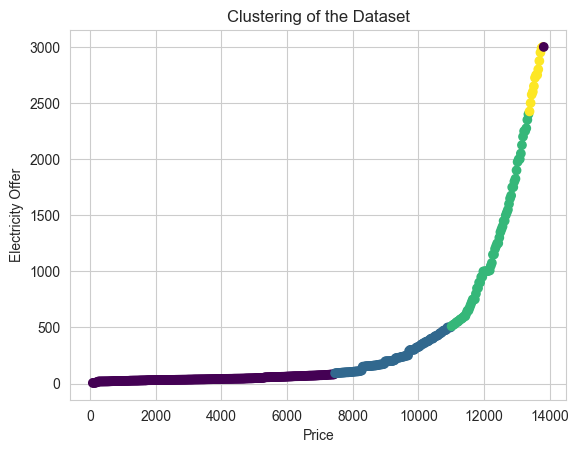

Hour:  21


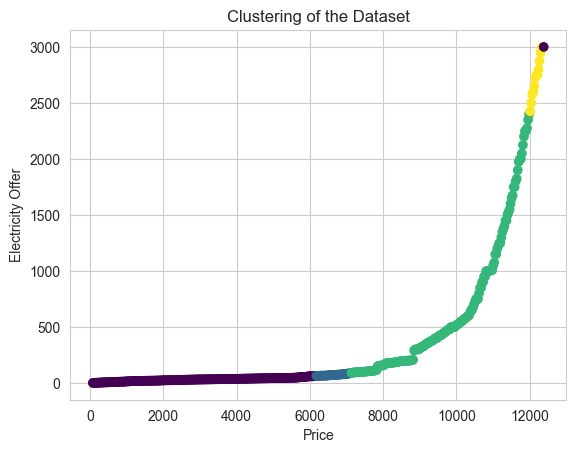

Hour:  22


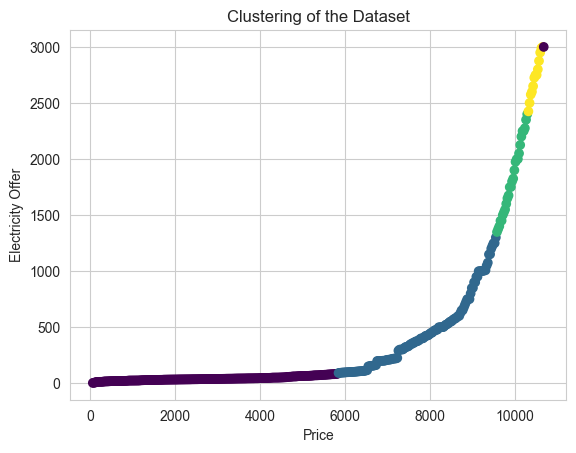

Hour:  23


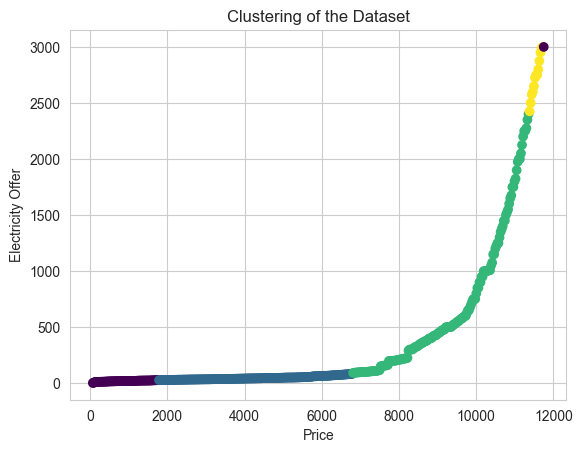

Hour:  24


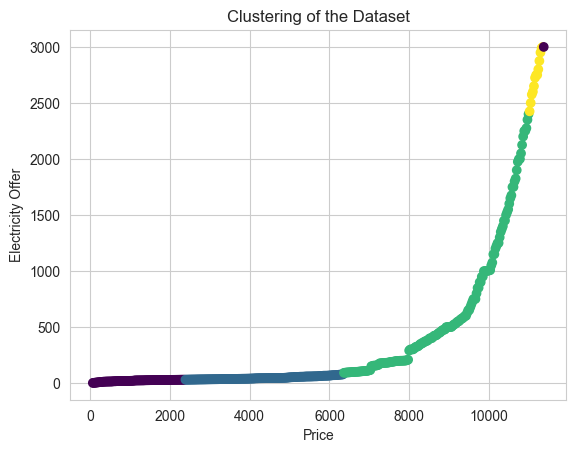

Hour: 1
   Price  Cumulative_Volume  Cumulative_Sum     Diff  diff_de_diff  Class
2    1.2            23.2520         69.7360  23.2520  0.000000e+00      0
3    1.7            23.2521         92.9881  23.2521  1.000000e-04      0
4    4.5            23.2521        116.2402  23.2521  0.000000e+00      0
5    4.7            23.2522        139.4924  23.2522  1.000000e-04      0
6    6.0            23.2522        162.7446  23.2522  2.842171e-14      0
Hour: 2
   Price  Cumulative_Volume  Cumulative_Sum     Diff  diff_de_diff  Class
2    0.2            24.9824         74.8977  24.9824        0.0200      0
3    0.9            24.9824         99.8801  24.9824        0.0000      0
4    1.0            24.9825        124.8626  24.9825        0.0001      0
5    2.0            24.9825        149.8451  24.9825        0.0000      0
6    2.2            24.9965        174.8416  24.9965        0.0140      0
Hour: 3
   Price  Cumulative_Volume  Cumulative_Sum     Diff  diff_de_diff  Class
2    0.2      

In [171]:
# Initialize the dictionary to store results
results_dict = {}

# Loop through each unique hour in the data
for hour in data['Hour'].unique():
    print("Hour: ", hour)
    # Filter the DataFrame to keep rows where 'Hour' is the current hour
    filtered_data = data[data['Hour'] == hour]
    filtered_data = filtered_data[filtered_data['Price'] > 0]
    # Group by 'Price' and calculate the cumulative sum of 'Volume'
    cumulative_volume = filtered_data.groupby('Price')['Volume'].cumsum() / 1000

    # Create a new DataFrame with 'Price' and 'Cumulative_Volume' columns
    cumulative_data = pd.DataFrame({'Price': filtered_data['Price'], 'Cumulative_Volume': cumulative_volume})

    # Drop duplicate rows to keep only unique 'Price' values
    cumulative_data = cumulative_data.drop_duplicates(subset='Price', keep='last')

    # Reset the index for the new DataFrame
    cumulative_data.reset_index(drop=True, inplace=True)

    # Sort the DataFrame by ascending 'Price'
    cumulative_data = cumulative_data.sort_values(by='Price')

    # Calculate the cumulative sum of 'Cumulative_Volume' and add it as a new column
    cumulative_data['Cumulative_Sum'] = cumulative_data['Cumulative_Volume'].cumsum()

    # Calculate the differences in the cumulative sum
    cumulative_data['Diff'] = cumulative_data['Cumulative_Sum'].diff()

    # Calculate the second-order differences
    cumulative_data['diff_de_diff'] = cumulative_data['Diff'].diff()
    cumulative_data = cumulative_data.iloc[2:]

    # Identify the three biggest jumps
    biggest_jumps = cumulative_data.nlargest(3, 'diff_de_diff')

    # Add an indicator column to define classes
    cumulative_data['Class'] = 0
    jump_indices = sorted(biggest_jumps.index)
    classes = range(len(jump_indices) + 1)

    start_idx = 0
    for class_label, end_idx in zip(classes, jump_indices + [len(cumulative_data)]):
        cumulative_data.loc[start_idx:end_idx, 'Class'] = class_label
        start_idx = end_idx + 1

    # Store the resulting DataFrame in the dictionary
    results_dict[hour] = cumulative_data

    plt.scatter(cumulative_data['Cumulative_Sum'],cumulative_data['Price'], c=cumulative_data['Class'], cmap='viridis')
    plt.xlabel('Price')
    plt.ylabel('Electricity Offer')
    plt.title('Clustering of the Dataset')
    plt.show()

# Display the dictionary with results for each hour
for hour, df in results_dict.items():
    print(f'Hour: {hour}')
    print(df.head())

In [170]:
# Define the list of technology columns
tech_columns = prod_data.columns[1:]

# Initialize a color map
colors = plt.cm.tab20(range(len(tech_columns)))

# Loop through each hour and plot the production with cost as height
for hour in prod_data['Hour']:
    # Select the row for the current hour
    row = prod_data[prod_data['Hour'] == hour].iloc[0][1:]  # Exclude 'Hour' column

    # Create a bar plot
    plt.figure(figsize=(10, 6))

    # Plot each technology with different colors
    x = np.arange(len(tech_columns))
    for idx, tech in enumerate(tech_columns):
        if tech in production_costs:
            cost = production_costs[tech]
            production = row[tech]
            plt.bar(x[idx], cost, color=colors[idx], edgecolor='white', width=prod_data[idx])

    # Set the title and labels
    plt.title(f'Production Cost for Hour {hour}')
    plt.xlabel('Technology')
    plt.ylabel('Cost (€)')
    plt.xticks(ticks=x, labels=tech_columns, rotation=45)

    # Show the plot
    plt.show()

KeyError: 0

<Figure size 1000x600 with 0 Axes>

In [ ]:
for hour in prod_data['Hour']:
    print(prod_data['Hour']==hour)